In [2]:
import duckdb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Step 1: Load data from DuckDB
con = duckdb.connect("/Users/koosha/00-My Files-00/My Works/GitHub/Repositories/BNPL_Customer_Data/BNPL_customer_data/dev.duckdb", read_only=True)
df = con.execute("SELECT * FROM stg_BNPL_customer").fetchdf()


In [ ]:
# Step 2: Prepare features
df = df.copy()
df['app_version'] = df['app_version'].astype(str)
df['app_version_encoded'] = df['app_version'].astype('category').cat.codes

features = [
    'age', 'avg_monthly_revenue', 'bnpl_amount',
    #'repayment_days_delay', --removed as it has direct relation with target feature
    'bnpl_repeat_count',
    'direct_channel_usage_share', 'recent_recharge_freq',
    'bundle_purchase_count', 'app_version_encoded'
]

X = df[features]
y = df['bnpl_default']


In [13]:
# Step 3: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [14]:
# Step 4: Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [15]:
# Step 5: Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2690
           1       0.50      0.00      0.01       310

    accuracy                           0.90      3000
   macro avg       0.70      0.50      0.48      3000
weighted avg       0.86      0.90      0.85      3000



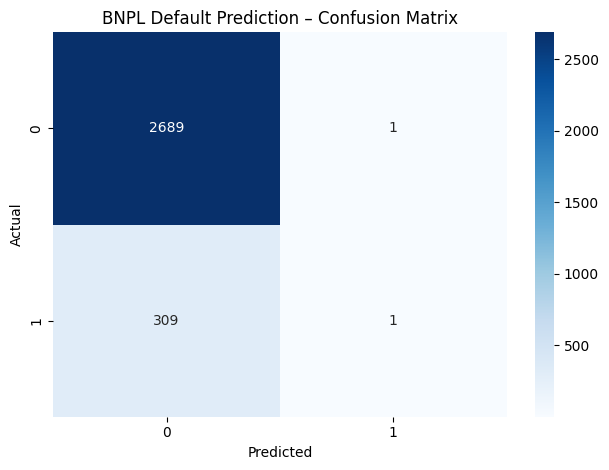

In [16]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("BNPL Default Prediction – Confusion Matrix")
plt.tight_layout()
plt.savefig("../results/confusion_matrix.png")
plt.show()

In [17]:
#Show top 10 features
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 important features:")
print(importances.head(10))

Top 10 important features:
bnpl_amount                   0.249103
direct_channel_usage_share    0.192056
avg_monthly_revenue           0.190505
age                           0.134999
recent_recharge_freq          0.075709
bundle_purchase_count         0.065043
app_version_encoded           0.049695
bnpl_repeat_count             0.042890
dtype: float64
